In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(harmony)
library(circlize)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Rcpp



Function modified from: https://ucdavis-bioinformatics-training.github.io/2020-Advanced_Single_Cell_RNA_Seq/data_analysis/VDJ_Analysis_fixed

In [2]:
add_clonotype <- function(tcr_prefix, seurat_obj, type="t"){
    tcr <- read.csv(tcr_prefix)

    # Remove the -1 at the end of each barcode.
    # Subsets so only the first line of each barcode is kept,
    # as each entry for given barcode will have same clonotype.
    tcr_a <- subset(tcr, chain == 'TRA')
    tcr_a <- tcr_a[!duplicated(tcr_a$barcode), ]
    tcr_b <- subset(tcr, chain == 'TRB')
    tcr_b <- tcr_b[!duplicated(tcr_b$barcode), ]

    # Only keep the barcode and clonotype columns. 
    # We'll get additional clonotype info from the clonotype table.
    tcr_a <- tcr_a[,c("barcode", "chain", "v_gene", "d_gene", "j_gene", "cdr3", "raw_clonotype_id")]
    colnames(tcr_a) <- c("barcode", "chain_a", "v_gene_a", "d_gene_a", "j_gene_a", "cdr3_a", "raw_clonotype_id_a")
    tcr_b <- tcr_b[,c("barcode", "chain", "v_gene", "d_gene", "j_gene", "cdr3", "raw_clonotype_id")]
    colnames(tcr_b) <- c("barcode", "chain_b", "v_gene_b", "d_gene_b", "j_gene_b", "cdr3_b", "raw_clonotype_id_b")
    # names(tcr)[names(tcr) == "raw_clonotype_id"] <- "clonotype_id"

    # Clonotype-centric info.
    # clono <- read.csv(paste(tcr_prefix,"clonotypes.csv", sep=""))

    # Slap the AA sequences onto our original table by clonotype_id.
    # tcr <- merge(tcr, clono[, c("clonotype_id", "cdr3s_aa")])
    # names(tcr)[names(tcr) == "cdr3s_aa"] <- "cdr3s_aa"

    # Reorder so barcodes are first column and set them as rownames.
    # tcr <- tcr[, c(2,1,3)]
    rownames(tcr_a) <- tcr_a$barcode
    tcr_a$barcode <- NULL
    rownames(tcr_b) <- tcr_b$barcode
    tcr_b$barcode <- NULL
    # colnames(tcr) <- paste(type, colnames(tcr), sep="_")
    # Add to the Seurat object's metadata.
    clono_seurat <- AddMetaData(object=seurat_obj, metadata=tcr_a)
    clono_seurat <- AddMetaData(object=clono_seurat, metadata=tcr_b)
    return(clono_seurat)
}

In [3]:
test <- read.csv(file = 'h5_files/TCR_BCR/GSM5073073_PBMC_P1.1_MIS-C_Severe_TCR_filtered_contig_annotations.csv.gz')
head(test)
length(rownames(test))
length(unique(test$barcode))

barcode            is_cell contig_id                   high_confidence length
1 AAACCTGCACCTCGTT-1 True    AAACCTGCACCTCGTT-1_contig_1 True            552   
2 AAACCTGCACCTCGTT-1 True    AAACCTGCACCTCGTT-1_contig_2 True            515   
3 AAACCTGCACCTCGTT-1 True    AAACCTGCACCTCGTT-1_contig_3 True            762   
4 AAACCTGCATCGACGC-1 True    AAACCTGCATCGACGC-1_contig_1 True            496   
5 AAACCTGGTCGCGTGT-1 True    AAACCTGGTCGCGTGT-1_contig_1 True            526   
6 AAACCTGGTCGCGTGT-1 True    AAACCTGGTCGCGTGT-1_contig_2 True            574   
  chain v_gene   d_gene j_gene  c_gene full_length productive
1 TRA   TRAV16   None   TRAJ4   TRAC   True        True      
2 TRB   TRBV6-1  None   TRBJ1-5 TRBC1  True        True      
3 TRB   None     None   TRBJ2-4 TRBC2  False       False     
4 TRB   TRBV7-3  None   TRBJ1-5 TRBC1  True        True      
5 TRB   TRBV11-2 None   TRBJ2-3 TRBC2  True        True      
6 TRA   TRAV8-2  None   TRAJ35  TRAC   True        True      
  cdr3               cdr3_nt                                               
1 CALFSGGYNKLIF      TGTGCTCTTTTTTCTGGTGGCTACAATAAGCTGATTTTT               
2 CASSDPGGTEGNQPQHF  TGTGCCAGCAGTGACCCGGGGGGGACGGAGGGCAATCAGCCCCAGCATTTT   
3 None               None                                                  
4 CASTKGSQPQHF       TGTGCCAGCACCAAGGGGAGTCAGCCCCAGCATTTT                  
5 CASSLELAGGPWTDTQYF TGTGCCAGCAGCTTAGAACTAGCGGGGGGGCCTTGGACAGATACGCAGTATTTT
6 CVVRRGGNVLHC       TGTGTTGTGAGGCGGGGTGGGAATGTGCTGCATTGC                  
  reads umis raw_clonotype_id raw_consensus_id       
1 7194  6    clonotype17      clonotype17_consensus_2
2 4805  5    clonotype17      clonotype17_consensus_1
3  565  1    clonotype17      None                   
4 9971  8    clonotype75      clonotype75_consensus_1
5 5953  9    clonotype76      clonotype76_consensus_1
6 1545  1    clonotype76      clonotype76_consensus_2

[1] 4210

[1] 1782

# Import Data

In [4]:
mtx_3055 <- Read10X(data.dir = 'h5_files/3055/')
so_3055 <- CreateSeuratObject(mtx_3055$`Gene Expression`, project = 'MIS-C Severe')
so_3055$sampleID <- '3055'
so_3055 <- add_clonotype(tcr_prefix = 'h5_files/TCR_BCR//GSM5073073_PBMC_P1.1_MIS-C_Severe_TCR_filtered_contig_annotations.csv.gz', seurat_obj = so_3055)
table(so_3055$chain_a)
table(so_3055$chain_b)

10X data contains more than one type and is being returned as a list containing matrices of each type.




 TRA 
1421 


 TRB 
1655 

In [5]:
head(so_3055@meta.data)

orig.ident   nCount_RNA nFeature_RNA sampleID chain_a
AAACCTGAGCCACCTG-1 MIS-C Severe  970        445         3055     NA     
AAACCTGAGTACACCT-1 MIS-C Severe  709        333         3055     NA     
AAACCTGCACATGACT-1 MIS-C Severe 2799       1285         3055     NA     
AAACCTGCACCTCGTT-1 MIS-C Severe 2777       1157         3055     TRA    
AAACCTGCACTTACGA-1 MIS-C Severe 1208        528         3055     NA     
AAACCTGCAGCTGCAC-1 MIS-C Severe 3041       1103         3055     NA     
                   v_gene_a d_gene_a j_gene_a cdr3_a        raw_clonotype_id_a
AAACCTGAGCCACCTG-1 NA       NA       NA       NA            NA                
AAACCTGAGTACACCT-1 NA       NA       NA       NA            NA                
AAACCTGCACATGACT-1 NA       NA       NA       NA            NA                
AAACCTGCACCTCGTT-1 TRAV16   None     TRAJ4    CALFSGGYNKLIF clonotype17       
AAACCTGCACTTACGA-1 NA       NA       NA       NA            NA                
AAACCTGCAGCTGCAC-1 NA       NA       NA       NA            NA                
                   chain_b v_gene_b d_gene_b j_gene_b cdr3_b           
AAACCTGAGCCACCTG-1 NA      NA       NA       NA       NA               
AAACCTGAGTACACCT-1 NA      NA       NA       NA       NA               
AAACCTGCACATGACT-1 NA      NA       NA       NA       NA               
AAACCTGCACCTCGTT-1 TRB     TRBV6-1  None     TRBJ1-5  CASSDPGGTEGNQPQHF
AAACCTGCACTTACGA-1 NA      NA       NA       NA       NA               
AAACCTGCAGCTGCAC-1 NA      NA       NA       NA       NA               
                   raw_clonotype_id_b
AAACCTGAGCCACCTG-1 NA                
AAACCTGAGTACACCT-1 NA                
AAACCTGCACATGACT-1 NA                
AAACCTGCACCTCGTT-1 clonotype17       
AAACCTGCACTTACGA-1 NA                
AAACCTGCAGCTGCAC-1 NA

In [6]:
mtx_3056 <- Read10X(data.dir = 'h5_files/3056/')
so_3056 <- CreateSeuratObject(mtx_3056$`Gene Expression`, project = 'MIS-C Severe')
so_3056$sampleID <- '3056'
so_3056 <- add_clonotype(tcr_prefix = 'h5_files/TCR_BCR//GSM5073074_PBMC_P2.1_MIS-C_Severe_TCR_filtered_contig_annotations.csv.gz', seurat_obj = so_3056)
table(so_3056$chain_a)
table(so_3056$chain_b)

10X data contains more than one type and is being returned as a list containing matrices of each type.




 TRA 
2348 


 TRB 
2513 

In [7]:
mtx_3057 <- Read10X(data.dir = 'h5_files/3057/')
so_3057 <- CreateSeuratObject(mtx_3057, project = 'MIS-C Severe')
so_3057$sampleID <- '3057'
so_3057 <- add_clonotype(tcr_prefix = 'h5_files/TCR_BCR//GSM5073075_PBMC_P3.1_MIS-C_Severe_TCR_filtered_contig_annotations.csv.gz', seurat_obj = so_3057)
# table(so_3057$chain)

In [8]:
mtx_3058 <- Read10X(data.dir = 'h5_files/3058/')
so_3058 <- CreateSeuratObject(mtx_3058, project = 'MIS-C Moderate')
so_3058$sampleID <- '3058'
so_3058 <- add_clonotype(tcr_prefix = 'h5_files/TCR_BCR//GSM5073076_PBMC_P4.1_MIS-C_Moderate_TCR_filtered_contig_annotations.csv.gz', seurat_obj = so_3058)
# table(so_3058$chain)

In [9]:
mtx_3059 <- Read10X(data.dir = 'h5_files/3059/')
so_3059 <- CreateSeuratObject(mtx_3059, project = 'MIS-C Moderate')
so_3059$sampleID <- '3059'
so_3059 <- add_clonotype(tcr_prefix = 'h5_files/TCR_BCR//GSM5073077_PBMC_P5.1_MIS-C_Moderate_TCR_filtered_contig_annotations.csv.gz', seurat_obj = so_3059)
# table(so_3059$chain)

In [10]:
mtx_3060 <- Read10X(data.dir = 'h5_files/3060/')
so_3060 <- CreateSeuratObject(mtx_3060, project = 'MIS-C Severe')
so_3060$sampleID <- '3060'
so_3060 <- add_clonotype(tcr_prefix = 'h5_files/TCR_BCR//GSM5073078_PBMC_P6.1_MIS-C_Severe_TCR_filtered_contig_annotations.csv.gz', seurat_obj = so_3060)
# table(so_3060$chain)

In [11]:
mtx_3061 <- Read10X(data.dir = 'h5_files/3061/')
so_3061 <- CreateSeuratObject(mtx_3061, project = 'MIS-C Severe')
so_3061$sampleID <- '3061'
so_3061 <- add_clonotype(tcr_prefix = 'h5_files/TCR_BCR//GSM5073079_PBMC_P7.1_MIS-C_Severe_TCR_filtered_contig_annotations.csv.gz', seurat_obj = so_3061)
table(so_3061$chain_a)
table(so_3061$chain_b)


TRA 
291 


TRB 
372 

In [12]:
mtx_3062 <- Read10X(data.dir = 'h5_files/3062/')
so_3062 <- CreateSeuratObject(mtx_3062, project = 'MIS-C Severe/Recovered')
so_3062$sampleID <- '3062'
so_3062 <- add_clonotype(tcr_prefix = 'h5_files/TCR_BCR//GSM5073080_PBMC_P3.2_MIS-C_Severe_Recovered_TCR_filtered_contig_annotations.csv.gz', seurat_obj = so_3062)
# table(so_3062$chain)

In [13]:
mtx_3063 <- Read10X(data.dir = 'h5_files/3063/')
so_3063 <- CreateSeuratObject(mtx_3063, project = 'MIS-C Moderate/Recovered')
so_3063$sampleID <- '3063'
so_3063 <- add_clonotype(tcr_prefix = 'h5_files/TCR_BCR//GSM5073081_PBMC_P4.2_MIS-C_Moderate_Recovered_TCR_filtered_contig_annotations.csv.gz', seurat_obj = so_3063)
# table(so_3063$chain)

In [14]:
mtx_3064 <- Read10X(data.dir = 'h5_files/3064/')
so_3064 <- CreateSeuratObject(mtx_3064, project = 'Healthy')
so_3064$sampleID <- '3064'
so_3064 <- add_clonotype(tcr_prefix = 'h5_files/TCR_BCR//GSM5073082_PBMC_C.HD1_Pediatric_healthy_donor_TCR_filtered_contig_annotations.csv.gz', seurat_obj = so_3064)
# table(so_3064$chain)

In [15]:
mtx_3065 <- Read10X(data.dir = 'h5_files/3065/')
so_3065 <- CreateSeuratObject(mtx_3065, project = 'Healthy')
so_3065$sampleID <- '3065'
so_3065 <- add_clonotype(tcr_prefix = 'h5_files/TCR_BCR//GSM5073083_PBMC_C.HD2_Pediatric_healthy_donor_TCR_filtered_contig_annotations.csv.gz', seurat_obj = so_3065)
# table(so_3065$chain)

In [16]:
mtx_3066 <- Read10X(data.dir = 'h5_files/3066/')
so_3066 <- CreateSeuratObject(mtx_3066, project = 'Healthy')
so_3066$sampleID <- '3066'
so_3066 <- add_clonotype(tcr_prefix = 'h5_files/TCR_BCR//GSM5073084_PBMC_C.HD3_Pediatric_healthy_donor_TCR_filtered_contig_annotations.csv.gz', seurat_obj = so_3066)
# table(so_3066$chain)

In [17]:
mtx_3067 <- Read10X(data.dir = 'h5_files/3067/')
so_3067 <- CreateSeuratObject(mtx_3067, project = 'Healthy')
so_3067$sampleID <- '3067'
so_3067 <- add_clonotype(tcr_prefix = 'h5_files/TCR_BCR//GSM5073085_PBMC_C.HD4_Pediatric_healthy_donor_TCR_filtered_contig_annotations.csv.gz', seurat_obj = so_3067)
# table(so_3067$chain)

In [18]:
mtx_3068 <- Read10X(data.dir = 'h5_files/3068/')
so_3068 <- CreateSeuratObject(mtx_3068, project = 'Healthy')
so_3068$sampleID <- '3068'
so_3068 <- add_clonotype(tcr_prefix = 'h5_files/TCR_BCR//GSM5073086_PBMC_C.HD5_Pediatric_healthy_donor_TCR_filtered_contig_annotations.csv.gz', seurat_obj = so_3068)
# table(so_3068$chain)

In [19]:
mtx_3069 <- Read10X(data.dir = 'h5_files/3069/')
so_3069 <- CreateSeuratObject(mtx_3069, project = 'Healthy')
so_3069$sampleID <- '3069'
so_3069 <- add_clonotype(tcr_prefix = 'h5_files/TCR_BCR//GSM5073087_PBMC_C.HD6_Pediatric_healthy_donor_TCR_filtered_contig_annotations.csv.gz', seurat_obj = so_3069)
# table(so_3069$chain)

# Merge Data

In [20]:
so_merge <- merge(x = so_3055, y = c(so_3056,so_3057,so_3058,so_3059,so_3060,so_3061,so_3062,so_3063,so_3064,so_3065,so_3066,so_3067,so_3068,so_3069))

Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


In [21]:
table(so_merge$orig.ident)


                 Healthy           MIS-C Moderate MIS-C Moderate/Recovered 
                   60107                    21160                    10625 
            MIS-C Severe   MIS-C Severe/Recovered 
                   33608                    10144 

In [22]:
table(so_merge$sampleID)


 3055  3056  3057  3058  3059  3060  3061  3062  3063  3064  3065  3066  3067 
 9375  5610  3034  8786 12374 10807  4782 10144 10625  9665  7776 10624 10994 
 3068  3069 
11413  9635 

In [23]:
so_merge

An object of class Seurat 
33538 features across 135644 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)

In [24]:
so_merge[["percent.mt"]] <- PercentageFeatureSet(so_merge, 
                                                           pattern = "^MT-")
so_merge <- subset(so_merge, subset = nFeature_RNA > 200 & percent.mt < 10) 

In [25]:
so_merge

An object of class Seurat 
33538 features across 131932 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)

# Import Clustered T Cell Object

In [26]:
t_cells <- readRDS('mis-c_integrated_t_cells.rds')

In [27]:
t_cells <- SetIdent(t_cells, value = 'sub.cluster')
mnp2 <- subset(t_cells, idents = '4_3')
mnp2

An object of class Seurat 
35863 features across 457 samples within 6 assays 
Active assay: RNA (33538 features, 0 variable features)
 5 other assays present: integrated, prediction.score.celltype.l1, prediction.score.celltype.l2, prediction.score.celltype.l3, predicted_ADT
 2 dimensional reductions calculated: pca, umap

# Subset TCR data to MNP-2 cells

In [28]:
tcr_mnp2 <- subset(so_merge, cells = colnames(mnp2[['RNA']]))

In [29]:
tcr_mnp2

An object of class Seurat 
33538 features across 457 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)

In [30]:
head(tcr_mnp2@meta.data)

orig.ident     nCount_RNA nFeature_RNA sampleID chain_a
CGACTTCGTCTTGTCC-1_2 MIS-C Severe   3149       1217         3056     NA     
GCTCCTACAGGGATTG-1_3 MIS-C Severe   3346       1490         3057     NA     
ACTATCTTCATACGGT-1_4 MIS-C Moderate 5174       1995         3058     NA     
CGAGCCAAGCAAATCA-1_4 MIS-C Moderate 3116       1392         3058     NA     
GACAGAGCATCACGAT-1_4 MIS-C Moderate 3092       1138         3058     TRA    
GCGCCAATCTGCGGCA-1_4 MIS-C Moderate 4817       1565         3058     TRA    
                     v_gene_a d_gene_a j_gene_a cdr3_a        
CGACTTCGTCTTGTCC-1_2 NA       NA       NA       NA            
GCTCCTACAGGGATTG-1_3 NA       NA       NA       NA            
ACTATCTTCATACGGT-1_4 NA       NA       NA       NA            
CGAGCCAAGCAAATCA-1_4 NA       NA       NA       NA            
GACAGAGCATCACGAT-1_4 TRAV34   None     TRAJ53   CGADIGGSNYKLTF
GCGCCAATCTGCGGCA-1_4 TRAV6    None     TRAJ13   CAPTSGGYQKVTF 
                     raw_clonotype_id_a chain_b v_gene_b d_gene_b j_gene_b
CGACTTCGTCTTGTCC-1_2 NA                 NA      NA       NA       NA      
GCTCCTACAGGGATTG-1_3 NA                 NA      NA       NA       NA      
ACTATCTTCATACGGT-1_4 NA                 NA      NA       NA       NA      
CGAGCCAAGCAAATCA-1_4 NA                 NA      NA       NA       NA      
GACAGAGCATCACGAT-1_4 clonotype2102      TRB     TRBV7-3  None     TRBJ2-7 
GCGCCAATCTGCGGCA-1_4 clonotype2400      TRB     TRBV11-2 None     TRBJ2-2 
                     cdr3_b             raw_clonotype_id_b percent.mt
CGACTTCGTCTTGTCC-1_2 NA                 NA                 3.9695141 
GCTCCTACAGGGATTG-1_3 NA                 NA                 2.7196653 
ACTATCTTCATACGGT-1_4 NA                 NA                 2.6285273 
CGAGCCAAGCAAATCA-1_4 NA                 NA                 2.3106547 
GACAGAGCATCACGAT-1_4 CASSLEIGQHYEQYF    clonotype2102      0.3557568 
GCGCCAATCTGCGGCA-1_4 CASRESPRRTGLTGELFF clonotype2400      2.0759809

In [31]:
table(tcr_mnp2$chain_a)
table(tcr_mnp2$chain_b)


TRA 
230 


TRB 
303 

In [40]:
table(tcr_mnp2$raw_clonotype_id_a == tcr_mnp2$raw_clonotype_id_b)


TRUE 
 222 

In [32]:
230/457*100
303/457*100

[1] 50.32823

[1] 66.30197

In [33]:
tcr_t_cells <- subset(so_merge, cells = colnames(t_cells[['RNA']]))
tcr_t_cells

An object of class Seurat 
33538 features across 72372 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)
 2 layers present: counts, data

In [ ]:
tcr_mnp2_subset <- subset(tcr_mnp2, orig.ident %in% c('Healthy','MIS-C Moderate/Recovered','MIS-C Severe/Recovered'))

# Ext Fig 10J

In [33]:
tra_subset <- subset(tcr_mnp2_subset@meta.data, chain_a == 'TRA')
tra_subset_healthy <- subset(tra_subset, orig.ident == 'Healthy')
tra_subset_healthy_trim <- tra_subset_healthy[,c('v_gene_a','j_gene_a')]
head(tra_subset_healthy_trim)
length(rownames(tra_subset_healthy_trim))

v_gene_a   j_gene_a
AAACCTGTCGCTTGTC-1_10 TRAV8-6    TRAJ42  
AAGACCTTCTATGTGG-1_10 TRAV3      TRAJ29  
ACACCAAAGCAATATG-1_10 TRAV8-4    TRAJ40  
ACACCGGGTCACAAGG-1_10 TRAV29/DV5 TRAJ24  
ACAGCTACATTTCAGG-1_10 TRAV12-2   TRAJ26  
ACTATCTCAGCGTAAG-1_10 TRAV3      TRAJ11

[1] 153

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not

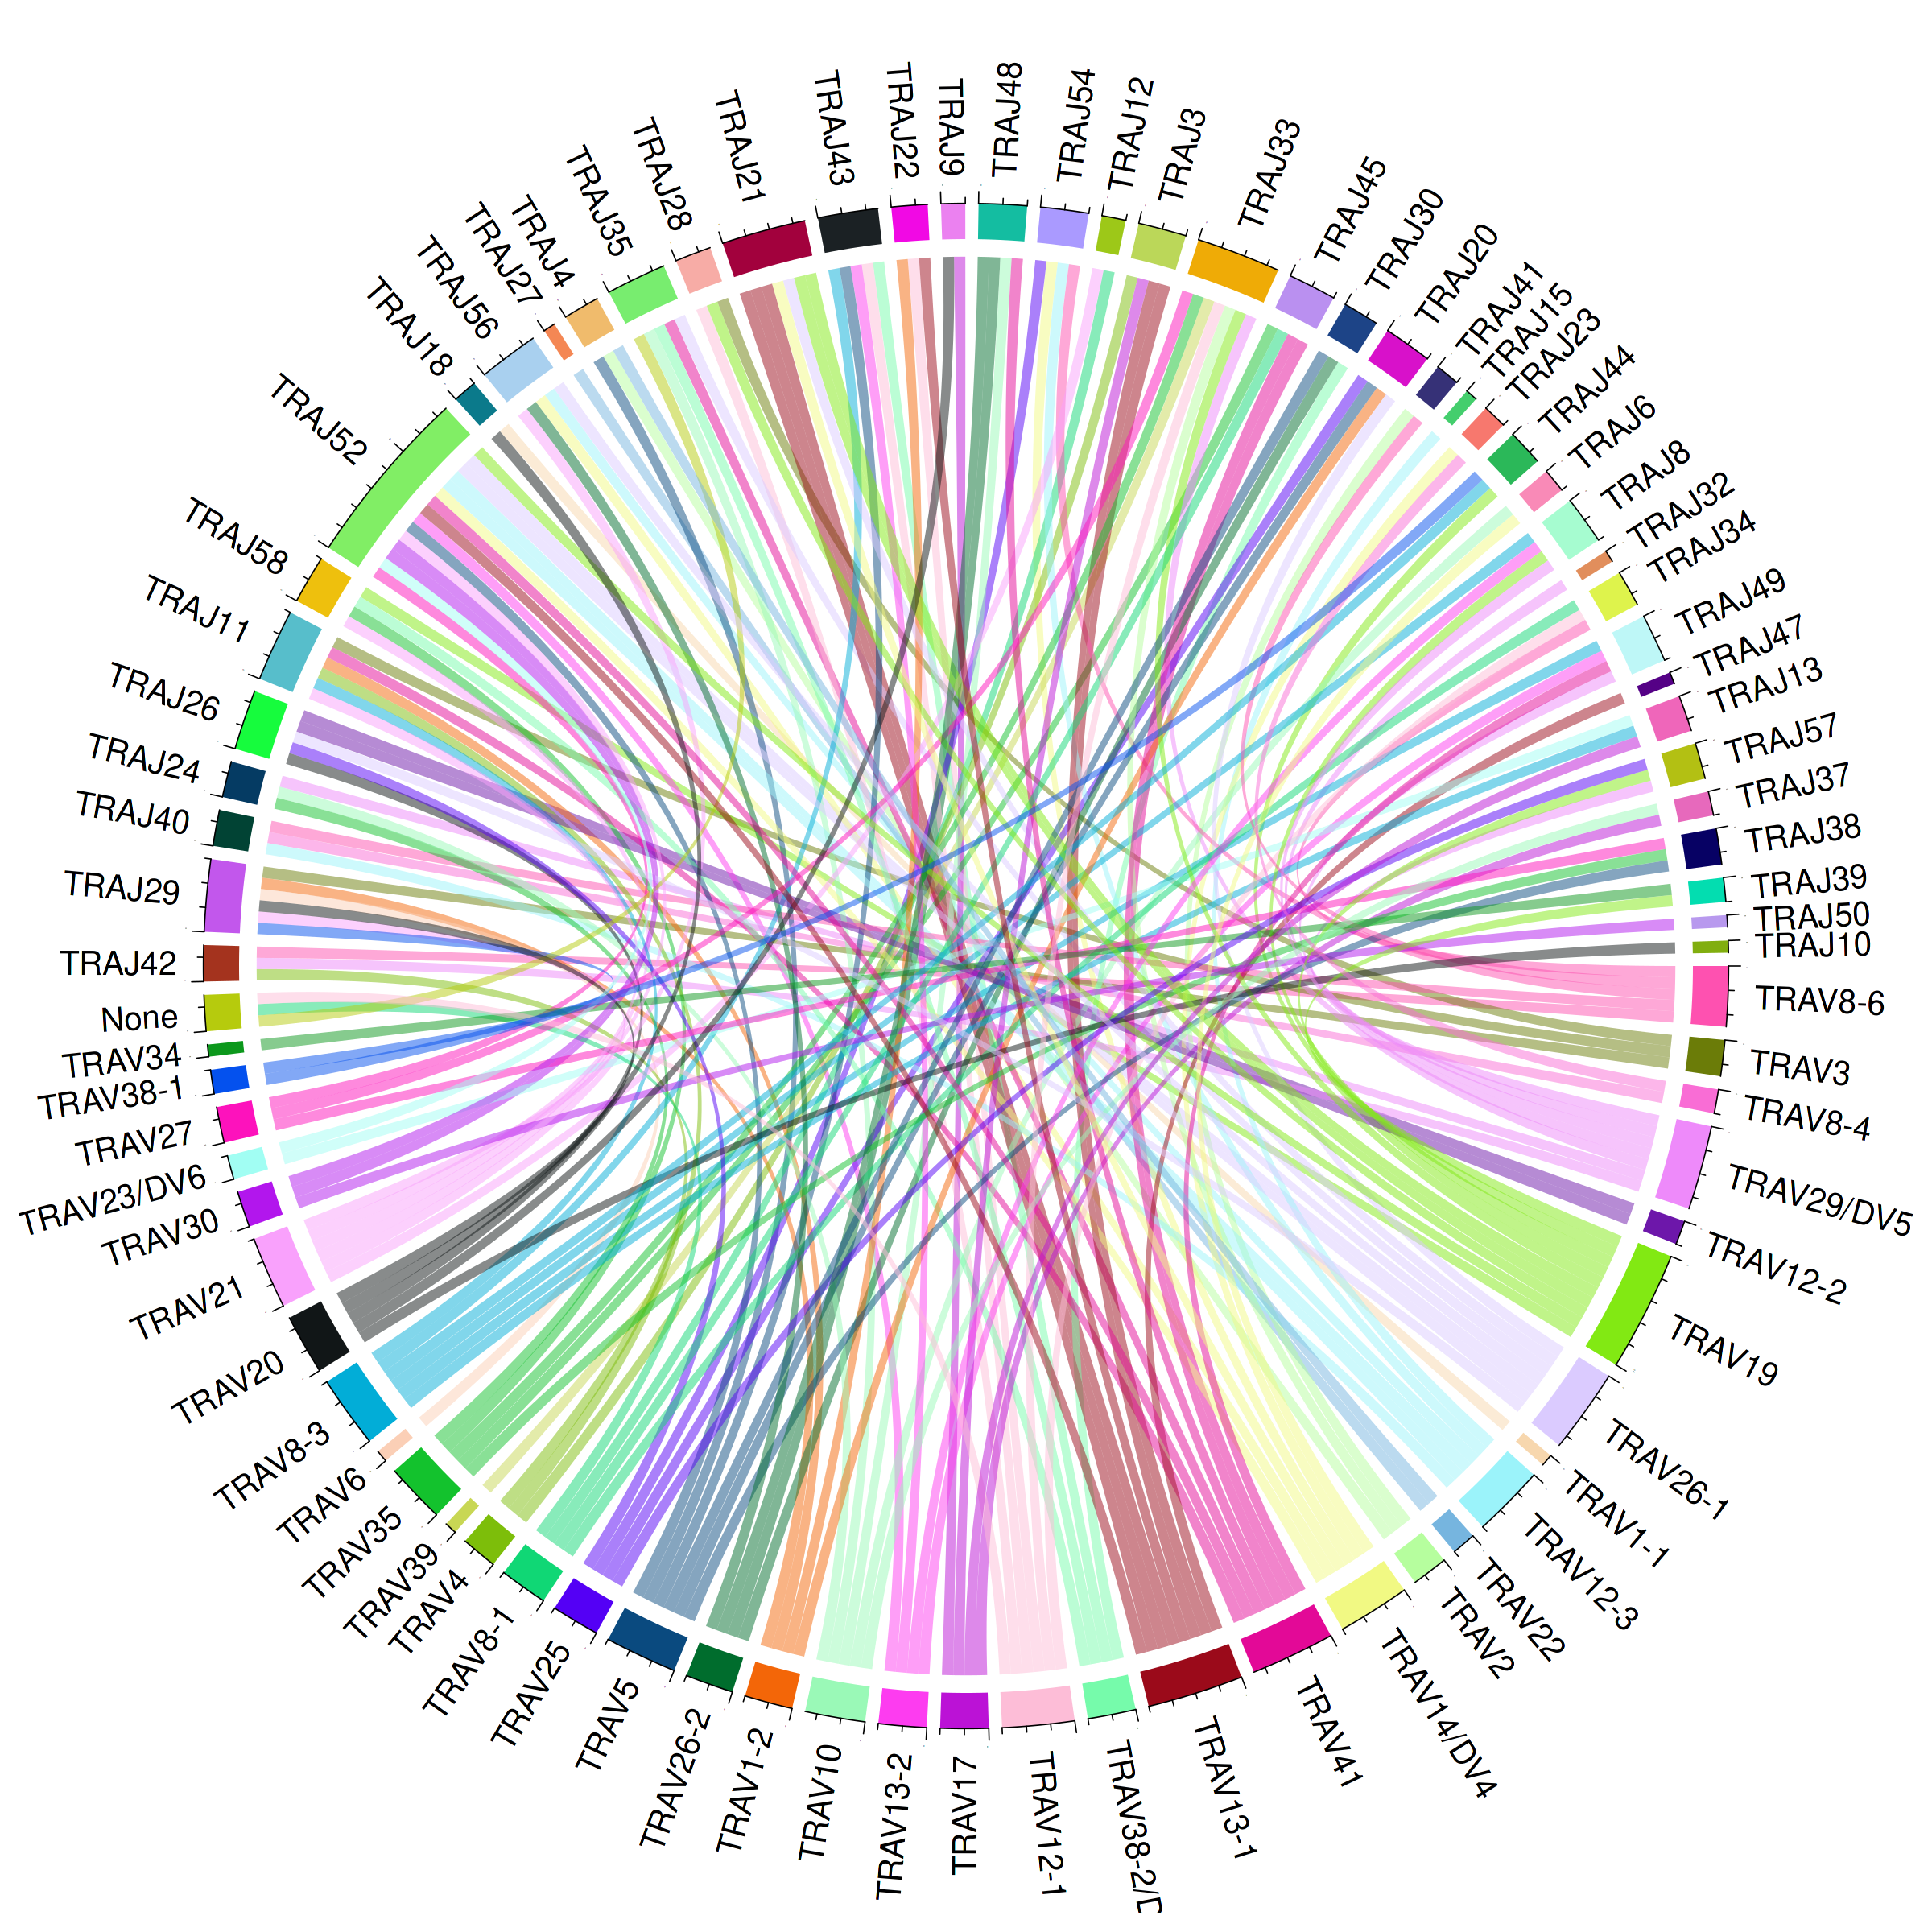

In [128]:
options(repr.plot.width = 20, repr.plot.height = 20)
# chordDiagram(tra_subset_healthy_trim)
chordDiagram(tra_subset_healthy_trim, annotationTrack = "grid", preAllocateTracks = 1)
circos.trackPlotRegion(track.index = 1, panel.fun = function(x, y) {
  xlim = get.cell.meta.data("xlim")
  ylim = get.cell.meta.data("ylim")
  sector.name = get.cell.meta.data("sector.index")
  circos.text(cex = 2, mean(xlim), ylim[1] + .1, sector.name, facing = "clockwise", niceFacing = TRUE, adj = c(0, 0.5))
  circos.axis(h = "top", labels.cex = 0.1, major.tick.percentage = 0.2, sector.index = sector.name, track.index = 2)
  # circos.axis(labels.cex = 0)
}, bg.border = NA)

In [134]:
# Open a pdf file
pdf("plots/tcr_alpha_mnp2_healthy.pdf", width = 20, height = 20) 
# 2. Create a plot
chordDiagram(tra_subset_healthy_trim, annotationTrack = "grid", preAllocateTracks = 1)
circos.trackPlotRegion(track.index = 1, panel.fun = function(x, y) {
  xlim = get.cell.meta.data("xlim")
  ylim = get.cell.meta.data("ylim")
  sector.name = get.cell.meta.data("sector.index")
  circos.text(cex = 2,mean(xlim), ylim[1] + .1, sector.name, facing = "clockwise", niceFacing = TRUE, adj = c(0, 0.5))
  circos.axis(h = "top", labels.cex = 0.5, major.tick.percentage = 0.2, sector.index = sector.name, track.index = 2)
}, bg.border = NA)
# Close the pdf file
dev.off() 

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not

png 
  2

In [34]:
trb_subset <- subset(tcr_mnp2_subset@meta.data, chain_b == 'TRB')
trb_subset_healthy <- subset(trb_subset, orig.ident == 'Healthy')
trb_subset_healthy_trim <- trb_subset_healthy[,c('v_gene_b','j_gene_b')]
head(trb_subset_healthy_trim)
length(rownames(trb_subset_healthy_trim))

v_gene_b j_gene_b
AAACCTGTCGCTTGTC-1_10 TRBV5-1  TRBJ1-2 
AAGACCTTCTATGTGG-1_10 TRBV5-1  TRBJ1-2 
ACACCAAAGCAATATG-1_10 TRBV11-2 TRBJ2-7 
ACACCGGGTCACAAGG-1_10 TRBV2    TRBJ2-7 
ACAGCTACATTTCAGG-1_10 TRBV9    TRBJ1-2 
ACTATCTCAGCGTAAG-1_10 TRBV6-5  TRBJ2-3

[1] 208

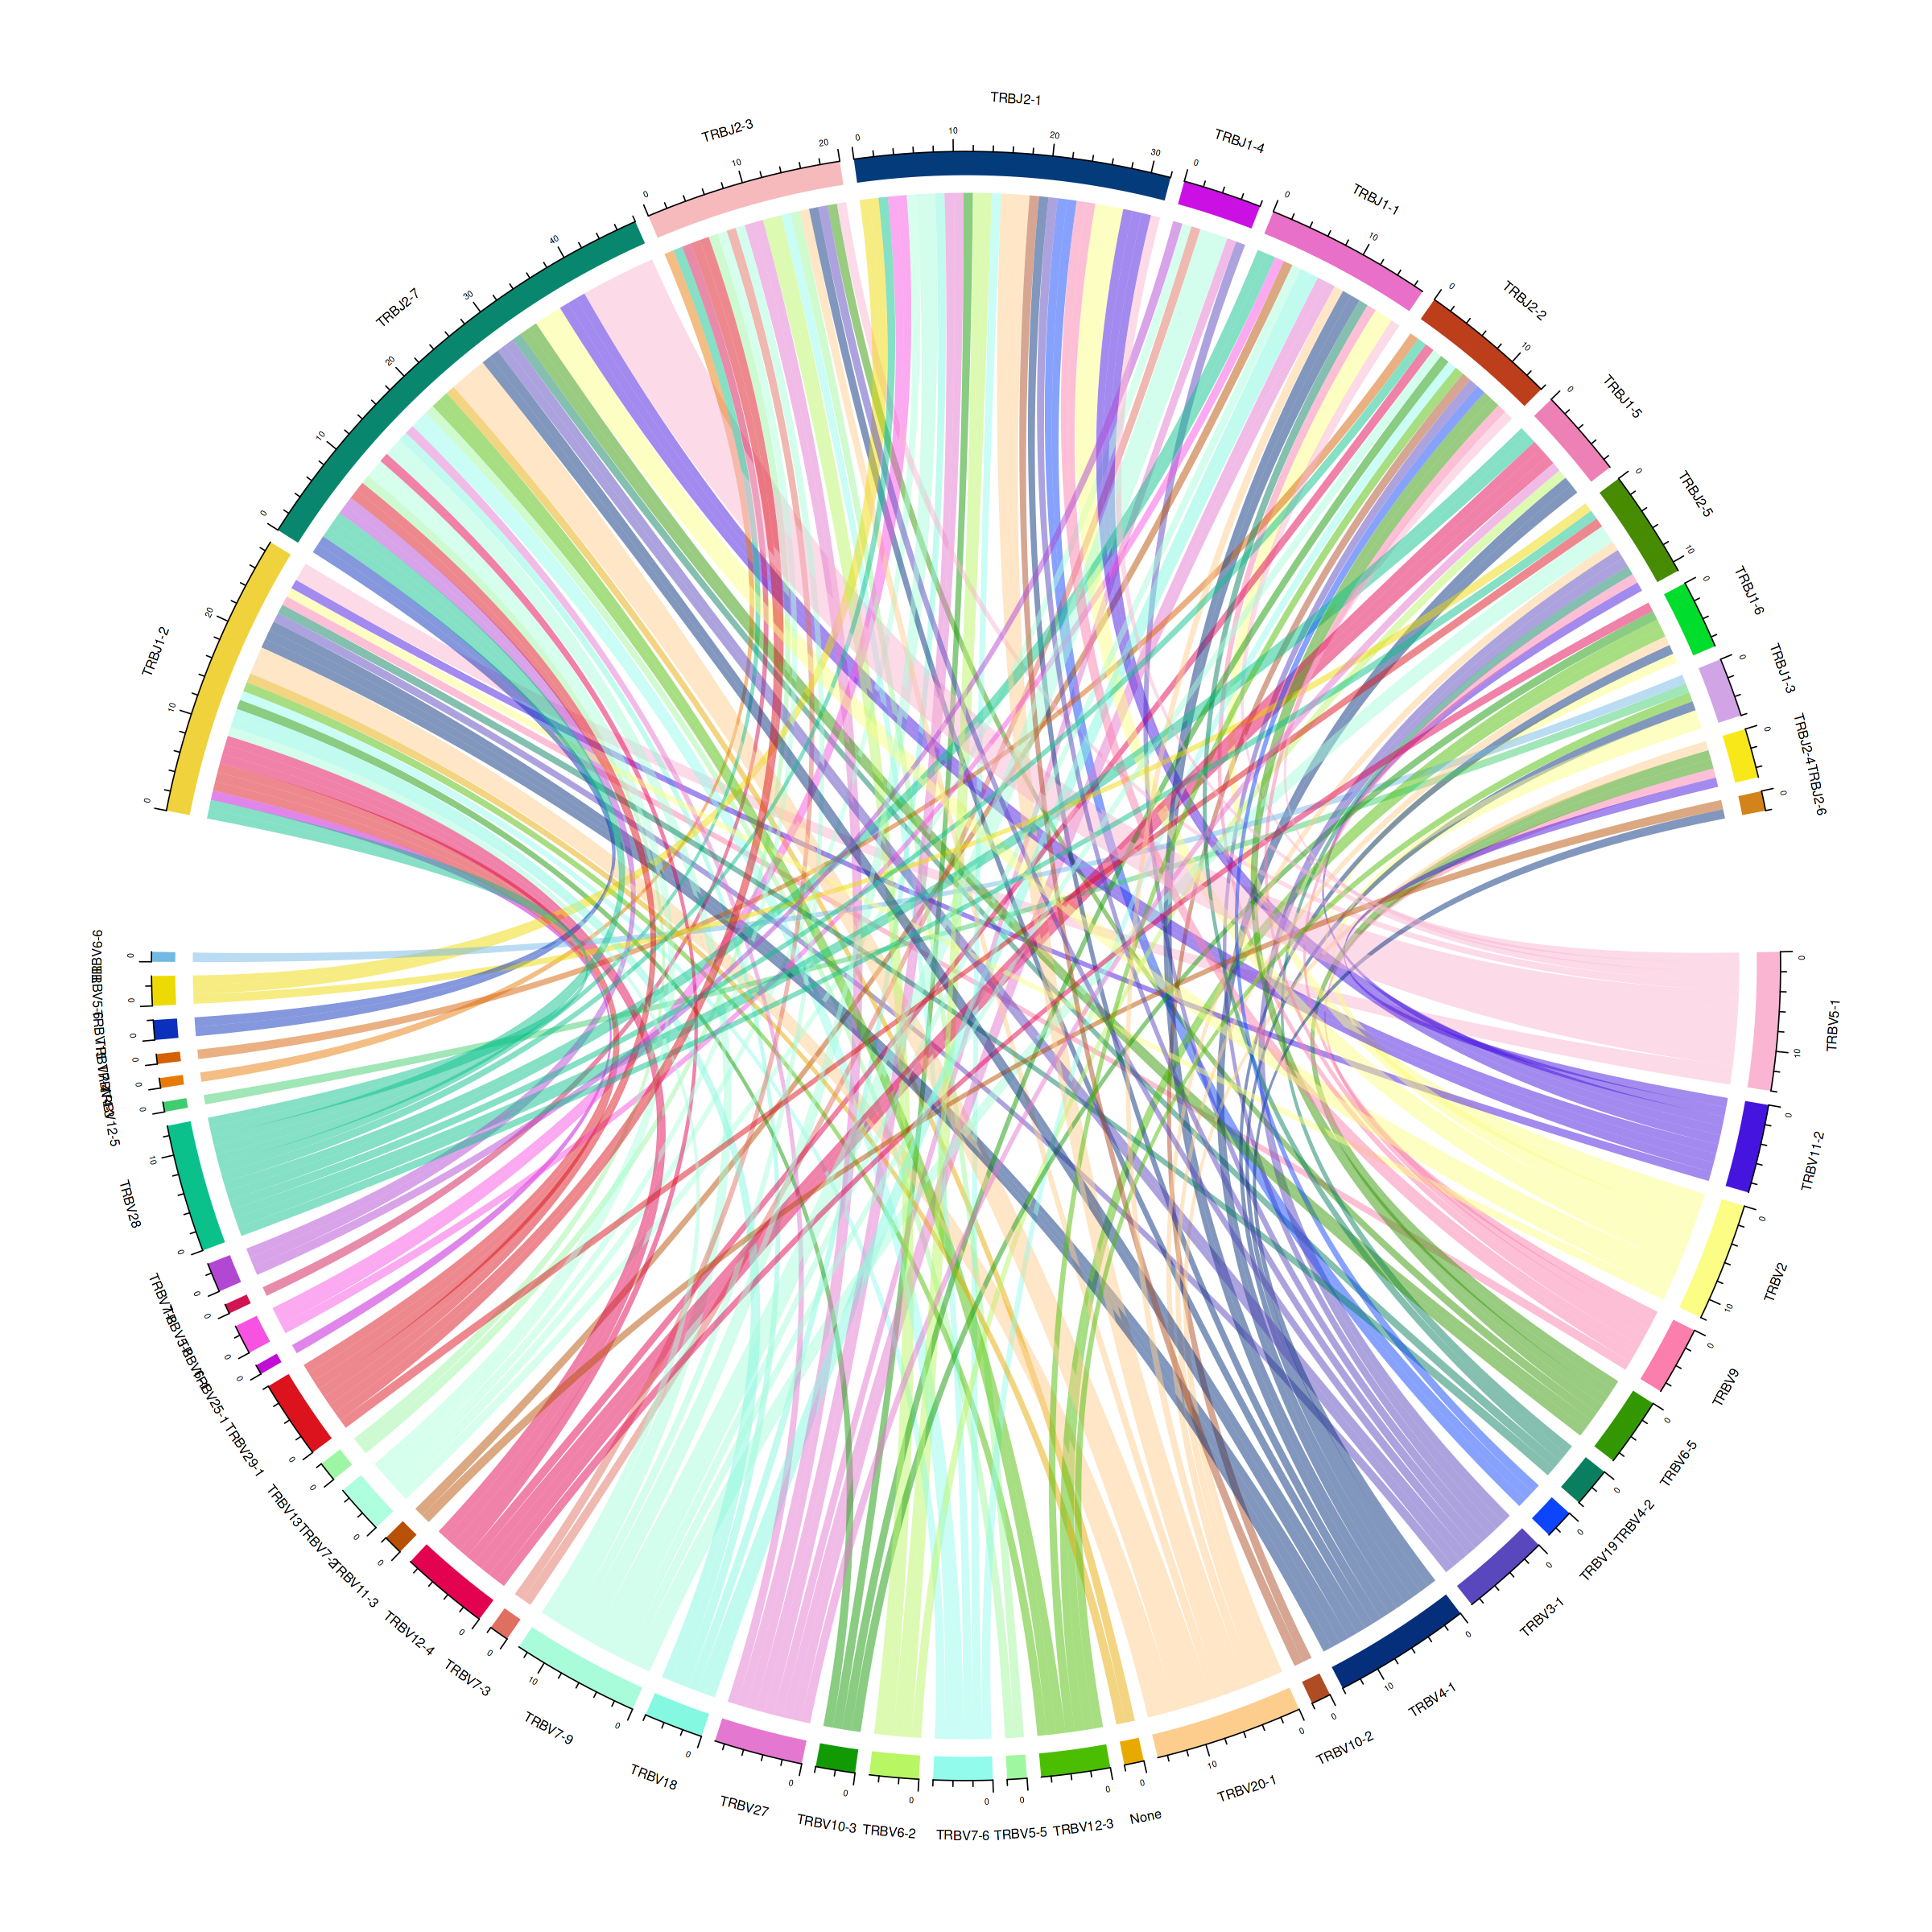

In [102]:
options(repr.plot.width = 20, repr.plot.height = 20)
chordDiagram(trb_subset_healthy_trim)

In [133]:
# Open a pdf file
pdf("plots/tcr_beta_mnp2_healthy.pdf", width = 20, height = 20) 
# 2. Create a plot
chordDiagram(trb_subset_healthy_trim, annotationTrack = "grid", preAllocateTracks = 1)
circos.trackPlotRegion(track.index = 1, panel.fun = function(x, y) {
  xlim = get.cell.meta.data("xlim")
  ylim = get.cell.meta.data("ylim")
  sector.name = get.cell.meta.data("sector.index")
  circos.text(cex = 2,mean(xlim), ylim[1] + .1, sector.name, facing = "clockwise", niceFacing = TRUE, adj = c(0, 0.5))
  circos.axis(h = "top", labels.cex = 0.5, major.tick.percentage = 0.2, sector.index = sector.name, track.index = 2)
}, bg.border = NA)
# Close the pdf file
dev.off() 

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not

png 
  2

In [35]:
trb_subset <- subset(tcr_mnp2_subset@meta.data, chain_b == 'TRB')
trb_subset_recovered <- subset(trb_subset, orig.ident %in% c('MIS-C Moderate/Recovered','MIS-C Severe/Recovered'))
trb_subset_recovered_trim <- trb_subset_recovered[,c('v_gene_b','j_gene_b')]
head(trb_subset_recovered_trim)
length(rownames(trb_subset_recovered_trim))

v_gene_b j_gene_b
AAAGATGAGTAGATGT-1_8 TRBV6-6  TRBJ1-1 
AAATGCCAGTCAAGCG-1_8 TRBV2    TRBJ1-5 
AAGGAGCTCTTGCATT-1_8 TRBV6-1  TRBJ1-6 
ACACTGACAGCTCGAC-1_8 TRBV3-1  TRBJ1-2 
ACATACGCAAGCGAGT-1_8 TRBV20-1 TRBJ2-3 
ACTGCTCCAAGAAGAG-1_8 TRBV4-1  TRBJ1-5

[1] 84

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not

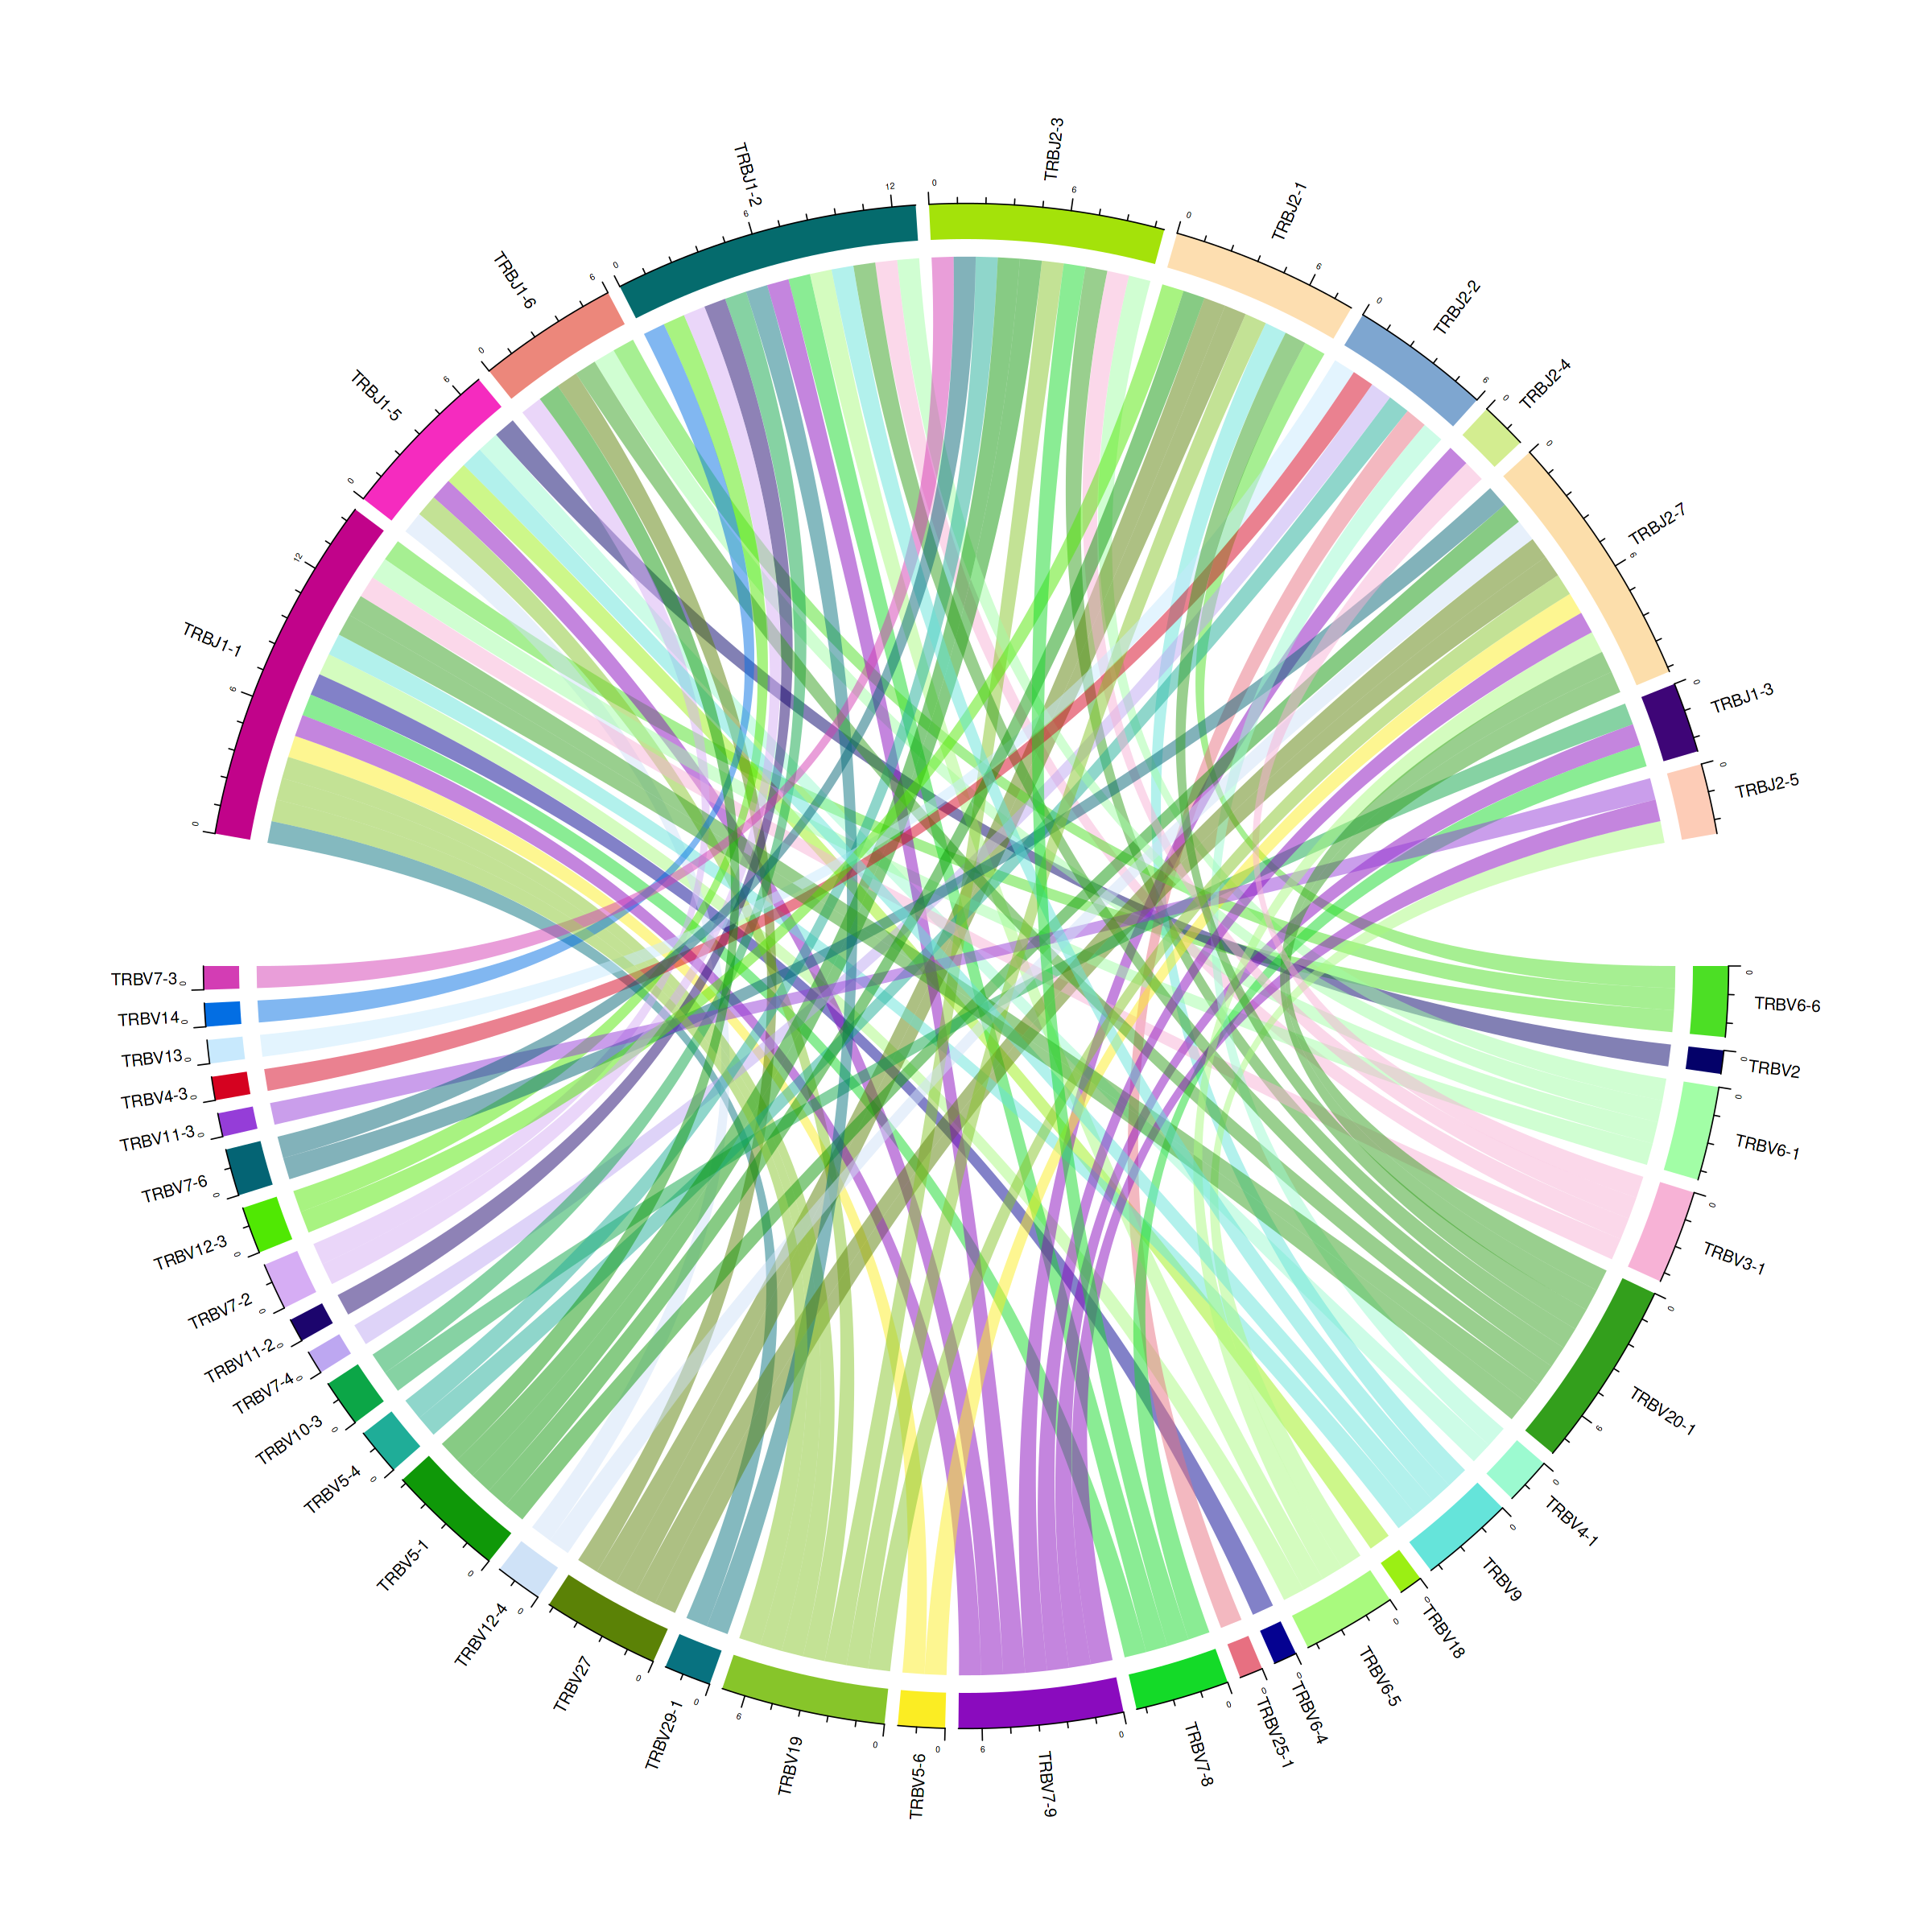

In [110]:
options(repr.plot.width = 20, repr.plot.height = 20)
# chordDiagram(trb_subset_recovered_trim)
chordDiagram(trb_subset_recovered_trim, annotationTrack = "grid", preAllocateTracks = 1)
circos.trackPlotRegion(track.index = 1, panel.fun = function(x, y) {
  xlim = get.cell.meta.data("xlim")
  ylim = get.cell.meta.data("ylim")
  sector.name = get.cell.meta.data("sector.index")
  circos.text(mean(xlim), ylim[1] + .1, sector.name, facing = "clockwise", niceFacing = TRUE, adj = c(0, 0.5))
  circos.axis(h = "top", labels.cex = 0.5, major.tick.percentage = 0.2, sector.index = sector.name, track.index = 2)
}, bg.border = NA)

In [36]:
tra_subset <- subset(tcr_mnp2_subset@meta.data, chain_a == 'TRA')
tra_subset_recovered <- subset(tra_subset, orig.ident %in% c('MIS-C Moderate/Recovered','MIS-C Severe/Recovered'))
tra_subset_recovered_trim <- tra_subset_recovered[,c('v_gene_a','j_gene_a')]
head(tra_subset_recovered_trim)
length(rownames(tra_subset_recovered_trim))

v_gene_a   j_gene_a
AAAGATGAGTAGATGT-1_8 TRAV9-2    TRAJ16  
AAATGCCAGTCAAGCG-1_8 TRAV4      TRAJ4   
AAGGAGCTCTTGCATT-1_8 TRAV13-1   TRAJ56  
ACATACGCAAGCGAGT-1_8 TRAV38-1   TRAJ31  
ACTTGTTGTGTTCTTT-1_8 TRAV14/DV4 TRAJ33  
AGAGCTTCAAAGCAAT-1_8 TRAV12-3   TRAJ3

[1] 67

In [131]:
# Open a pdf file
pdf("plots/tcr_alpha_mnp2_recovered.pdf", width = 20, height = 20) 
# 2. Create a plot
chordDiagram(tra_subset_recovered_trim, annotationTrack = "grid", preAllocateTracks = 1)
circos.trackPlotRegion(track.index = 1, panel.fun = function(x, y) {
  xlim = get.cell.meta.data("xlim")
  ylim = get.cell.meta.data("ylim")
  sector.name = get.cell.meta.data("sector.index")
  circos.text(cex = 2,mean(xlim), ylim[1] + .1, sector.name, facing = "clockwise", niceFacing = TRUE, adj = c(0, 0.5))
  circos.axis(h = "top", labels.cex = 0.5, major.tick.percentage = 0.2, sector.index = sector.name, track.index = 2)
}, bg.border = NA)
# Close the pdf file
dev.off() 

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not

png 
  2

In [132]:
# Open a pdf file
pdf("plots/tcr_beta_mnp2_recovered.pdf", width = 20, height = 20) 
# 2. Create a plot
chordDiagram(trb_subset_recovered_trim, annotationTrack = "grid", preAllocateTracks = 1)
circos.trackPlotRegion(track.index = 1, panel.fun = function(x, y) {
  xlim = get.cell.meta.data("xlim")
  ylim = get.cell.meta.data("ylim")
  sector.name = get.cell.meta.data("sector.index")
  circos.text(cex = 2,mean(xlim), ylim[1] + .1, sector.name, facing = "clockwise", niceFacing = TRUE, adj = c(0, 0.5))
  circos.axis(h = "top", labels.cex = 0.5, major.tick.percentage = 0.2, sector.index = sector.name, track.index = 2)
}, bg.border = NA)
# Close the pdf file
dev.off() 

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not

png 
  2